In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

import pysal.lib.examples as examples
import pysal.lib.weights as weights

import networkx as nx
import access

from geopy.distance import distance,geodesic

GEODATA_PATH = 'data/geodata/'
OUTPUT_PATH = 'data/output/'

In [2]:
crs_constant = "EPSG:4326"

brgys_geodata = gpd.read_file(GEODATA_PATH+'AdministrativeBoundariesBARMMBarangays20190206PSA2016/AdministrativeBoundariesBARMMBarangays20190206PSA2016.shp')
brgys_geodata = brgys_geodata.to_crs(crs_constant)

cond = brgys_geodata['Reg_Code']=='PH150000000'
brgys_geodata=brgys_geodata[cond].reset_index(drop=True)

brgys_geodata["centroid"] = brgys_geodata["geometry"].centroid
print("brgys_geodata",brgys_geodata.shape)

roads_intersects = pd.read_csv(OUTPUT_PATH+'RoadsARMM_OSM2019_Intersects_Clean.csv')
roads_intersects["osm_id"] = roads_intersects["osm_id"].astype(str)

roads_geodata = gpd.read_file(OUTPUT_PATH+'RoadsARMM_OSM2019_Geodata_Clean/RoadsARMM_OSM2019_Geodata_Clean.shp')
roads_geodata = roads_geodata.to_crs(crs_constant)

roads_geodata = roads_geodata.merge(roads_intersects,on="osm_id",how="left")
print("roads_geodata",roads_geodata.shape)

schools_geodata = gpd.read_file(OUTPUT_PATH+'SchoolsDepEd2017_Geodata_Clean/SchoolsDepEd2017_Geodata_Clean.shp')
schools_geodata = schools_geodata.to_crs(crs_constant)
schools_geodata.dropna(subset=["PSGC_BRGY"],inplace=True)

cond = (schools_geodata["geometry"].x>0) &(schools_geodata["geometry"].y>0)
schools_geodata = schools_geodata[cond].reset_index(drop=True)
print("schools_geodata",schools_geodata.shape)

brgys_geodata (2489, 10)
roads_geodata (1178, 7)
schools_geodata (2533, 13)


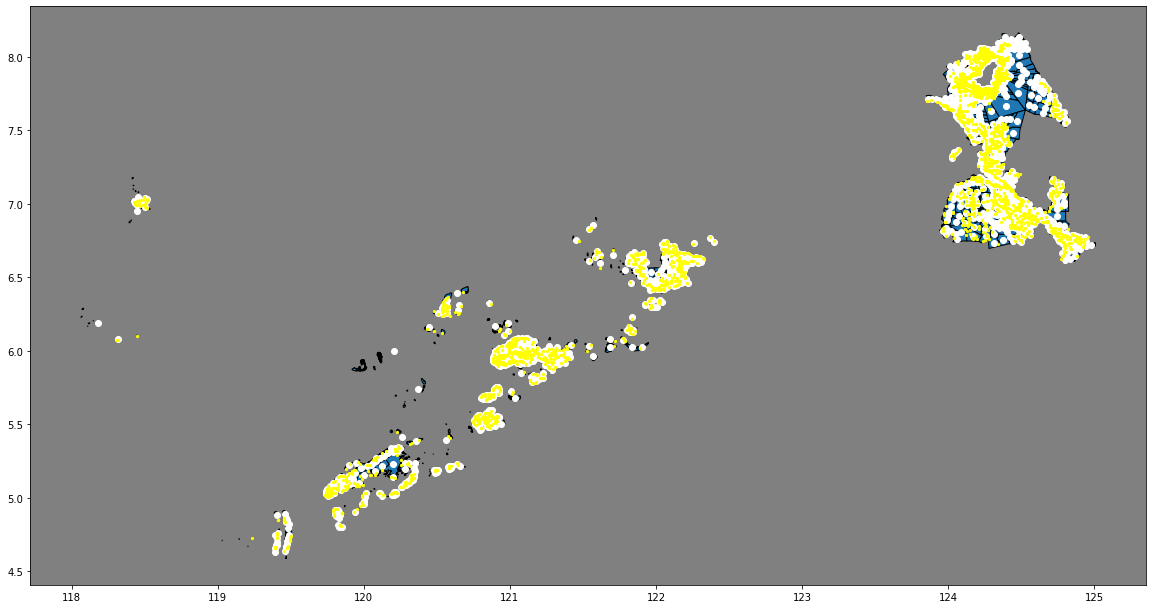

In [3]:
base = brgys_geodata.plot(figsize=(20,20),edgecolor='k')
brgys_geodata["centroid"].plot(ax=base,color="white")
schools_geodata.plot(ax=base,color="Yellow",markersize = 5)
base.set_facecolor('grey');

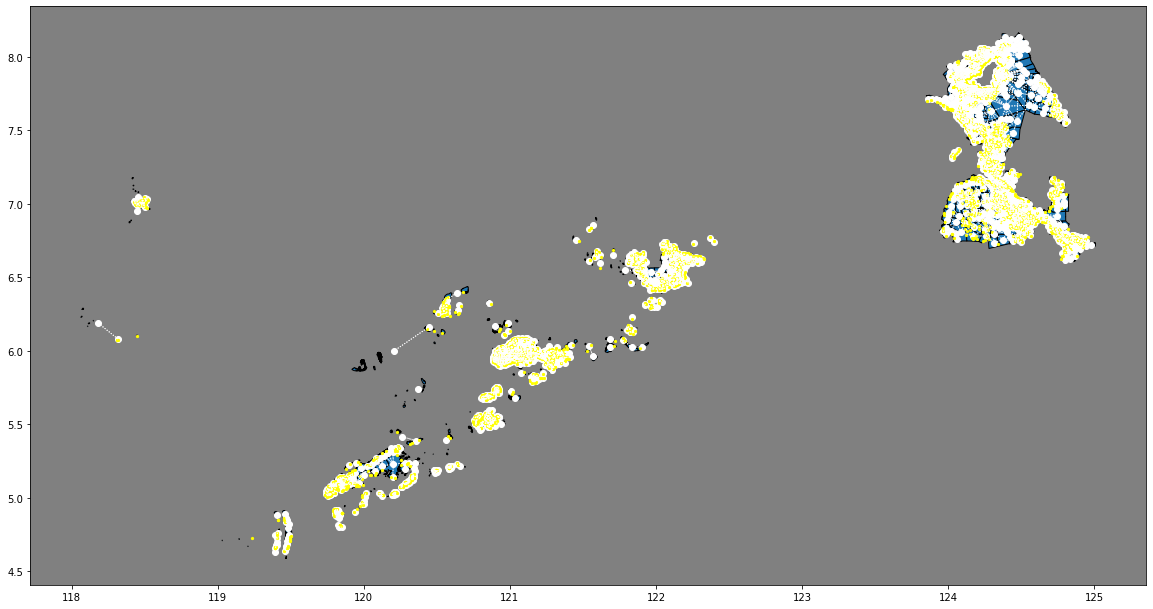

In [4]:
spatial_weights = weights.contiguity.Queen.from_dataframe(brgys_geodata)
base = brgys_geodata.plot(figsize=(20,20), edgecolor='k')
spatial_weights.plot(brgys_geodata, ax=base, 
        edge_kws=dict(color='white', linestyle=':', linewidth=1),
        node_kws=dict(marker=''))
brgys_geodata["centroid"].plot(ax=base,color="white")
schools_geodata.plot(ax=base,color="Yellow",markersize = 5)
base.set_facecolor('grey');

In [5]:
def get_PSGC_via_index(index,df,col):
    return df.loc[index,col]

def get_coord_values_in(index,df,col):
    lon = df.loc[index,col].x
    lat = df.loc[index,col].y
    return (lat,lon)

def get_km_dist_two_coord_series(coords1,coords2):
    dists = []
    for coord1,coord2 in zip(coords1,coords2):
        dists.append(geodesic(coord1,coord2).km)
    return dists

In [6]:
weights_nx = spatial_weights.to_networkx()
weights_df = nx.to_pandas_edgelist(weights_nx,nodelist=list(weights_nx.nodes))
weights_df.drop(columns="weight",inplace=True)

weights_df["source_PSGC"] = weights_df["source"].apply(get_PSGC_via_index,df=brgys_geodata,col="Bgy_Code")
weights_df["target_PSGC"] = weights_df["target"].apply(get_PSGC_via_index,df=brgys_geodata,col="Bgy_Code")

weights_df["source_coords"] = weights_df["source"].apply(get_coord_values_in,df=brgys_geodata,col="centroid")

psgc_df = weights_df.groupby("source_PSGC",as_index=False)["target_PSGC"].apply(lambda x: "%s" % '|'.join(x))
psgc_df["target_PSGC"] = psgc_df["source_PSGC"]+"|"+psgc_df["target_PSGC"]

schools = schools_geodata[["SCH_ID","PSGC_BRGY","geometry"]]
schools.dropna(subset=["PSGC_BRGY"],inplace=True)
schools.head()

source_target_df = pd.DataFrame()

no_schools_source = []

for source,targets in psgc_df.values:
    cond = schools["PSGC_BRGY"].str.contains(targets)
    
    if (sum(cond))==0:
        no_schools_source.append(source)
        continue
    
    _sub_df = schools[cond]
    _sub_df["source_PSGC"] = source
    source_target_df = source_target_df.append(_sub_df)
    
print(len(no_schools_source),"Brgy with No schools even in neighboring Brgys")
source_target_df = source_target_df.reset_index(drop=True)
source_target_df.head()

117 Brgy with No schools even in neighboring Brgys


,SCH_ID,PSGC_BRGY,geometry,source_PSGC
0,215012,PH150705032,POINT (122.02839 6.48405),PH150702001
1,133147,PH150711006,POINT (122.14088 6.56266),PH150702001
2,133122,PH150705032,POINT (122.04053 6.49356),PH150702001
3,133152,PH150711009,POINT (122.14628 6.55959),PH150702001
4,133002,PH150702034,POINT (122.10641 6.61121),PH150702001


In [7]:
def get_coord_via_PSGC(psgc,df,psgc_col="Bgy_Code",coord_col="centroid"):
    cond = df[psgc_col].str.contains(psgc)
    lon = df.loc[cond,coord_col].x.values[0]
    lat = df.loc[cond,coord_col].y.values[0]
    return (lat,lon)

def to_coord_tuple(point):
    lon = point.x
    lat = point.y
    return (lat,lon)

In [8]:
source_target_df["source_coords"]=source_target_df["source_PSGC"].apply(get_coord_via_PSGC,
                                                                        df=brgys_geodata)

source_target_df["target_coords"] = source_target_df["geometry"].apply(to_coord_tuple)

source_target_df["km_distance"] = get_km_dist_two_coord_series(source_target_df["source_coords"],source_target_df["target_coords"])
source_target_df

,SCH_ID,PSGC_BRGY,geometry,source_PSGC,source_coords,target_coords,km_distance
0,215012,PH150705032,POINT (122.02839 6.48405),PH150702001,"(6.5796566114442445, 122.08125254537643)","(6.48405, 122.028386)",12.082109
1,133147,PH150711006,POINT (122.14088 6.56266),PH150702001,"(6.5796566114442445, 122.08125254537643)","(6.562664, 122.140877)",6.856591
2,133122,PH150705032,POINT (122.04053 6.49356),PH150702001,"(6.5796566114442445, 122.08125254537643)","(6.493556, 122.040528)",10.533338
3,133152,PH150711009,POINT (122.14628 6.55959),PH150702001,"(6.5796566114442445, 122.08125254537643)","(6.559589, 122.146275)",7.525710
4,133002,PH150702034,POINT (122.10641 6.61121),PH150702001,"(6.5796566114442445, 122.08125254537643)","(6.611212, 122.106412)",4.463090
...,...,...,...,...,...,...,...
8512,134836,PH157011012,POINT (119.49609 4.71821),PH157011009,"(4.727084547093463, 119.48075985932451)","(4.718211, 119.496092)",1.963744
8513,134836,PH157011012,POINT (119.49609 4.71821),PH157011012,"(4.718579046319661, 119.4785222506224)","(4.718211, 119.496092)",1.949696
8514,134837,PH157011013,POINT (119.49200 4.70631),PH157011012,"(4.718579046319661, 119.4785222506224)","(4.706311, 119.492004)",2.019324
8515,134837,PH157011013,POINT (119.49200 4.70631),PH157011013,"(4.703412596623354, 119.476021284075)","(4.706311, 119.492004)",1.801966


In [9]:
cols = ["source_PSGC","SCH_ID","km_distance"]
cost_matrix = source_target_df[cols]
cost_matrix["mins_travel_time"] = 60 * cost_matrix["km_distance"]/1 #km/hour

In [10]:
pop_brgy = pd.read_csv(OUTPUT_PATH+"Population_Schools_SDGs_Clean.csv")
pop_brgy = pop_brgy[["PSGC_BRGY","both_age_6_to_16"]]

brgys = brgys_geodata[["Bgy_Code","geometry"]]
brgys = pd.merge(brgys,pop_brgy,left_on="Bgy_Code",right_on="PSGC_BRGY",how="left")
brgys = brgys[["PSGC_BRGY","geometry","both_age_6_to_16"]]
brgys.head()

,PSGC_BRGY,geometry,both_age_6_to_16
0,PH157001001,"MULTIPOLYGON (((119.95374 5.07851, 119.95384 5...",1610.0
1,PH157001002,"POLYGON ((119.88709 5.06919, 119.88709 5.06920...",874.0
2,PH157001003,"MULTIPOLYGON (((120.06363 5.16131, 120.06365 5...",1248.0
3,PH157001004,"POLYGON ((120.13585 5.19601, 120.13584 5.19603...",525.0
4,PH157001005,"MULTIPOLYGON (((119.98776 4.98564, 119.98774 4...",609.0


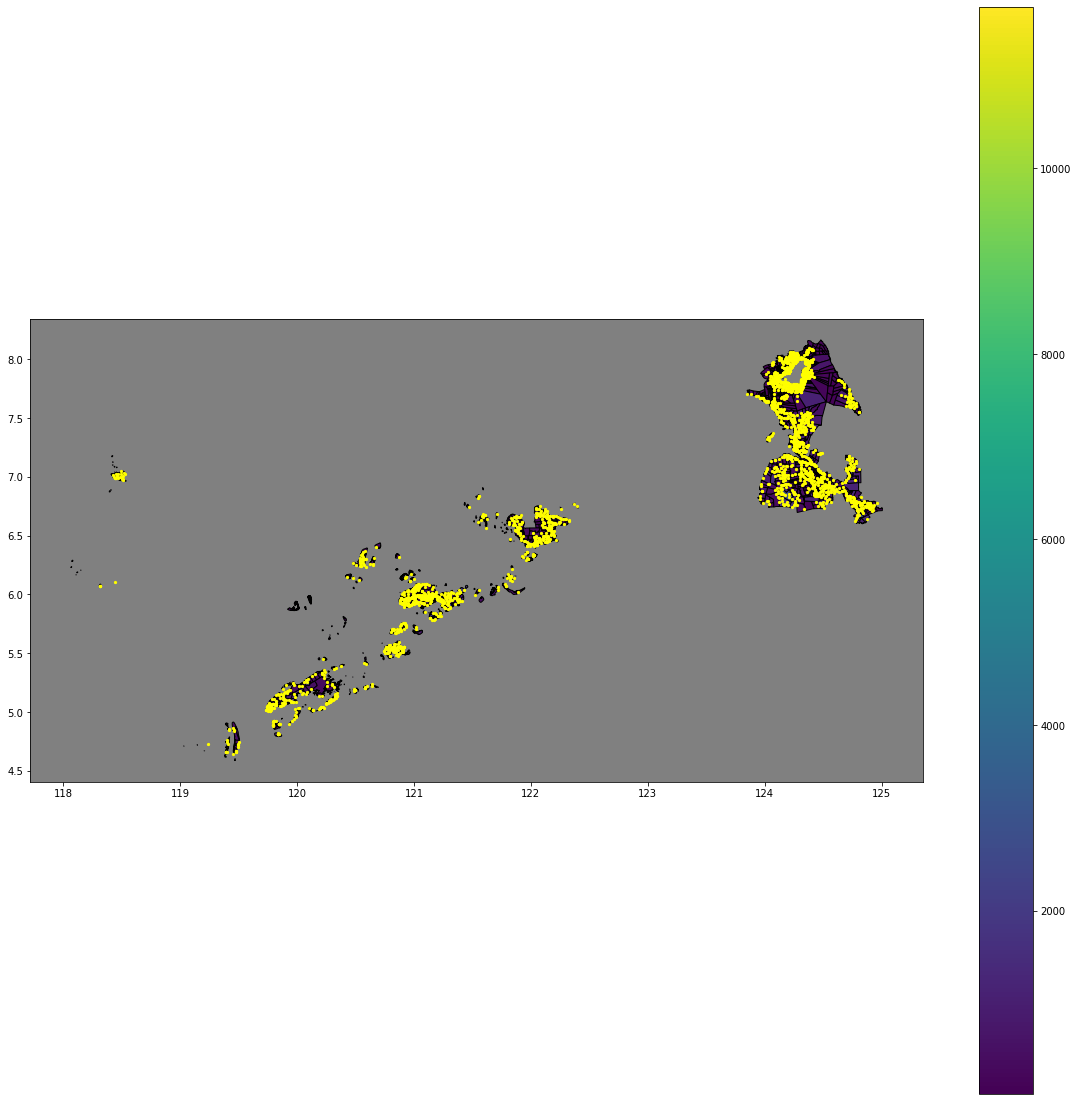

In [11]:
base = brgys.plot(figsize=(20,20),column="both_age_6_to_16",edgecolor='k',legend=True)
schools.plot(ax=base,color="Yellow",markersize = 5)
base.set_facecolor('grey');

In [12]:
brgys_w_schools = gpd.sjoin(schools, brgys[['PSGC_BRGY', 'geometry']],
                                  how='inner', op='intersects')
brgys_w_schools = brgys_w_schools.drop(columns=['index_right',"PSGC_BRGY_right"])
brgys_w_schools = brgys_w_schools.rename(columns={"PSGC_BRGY_left":"PSGC_BRGY"})
brgys_w_schools.head()

,SCH_ID,PSGC_BRGY,geometry
0,133049,PH150704001,POINT (121.91094 6.50770)
1,215015,PH150708008,POINT (122.19572 6.66413)
17,133181,PH150708003,POINT (122.18477 6.66491)
38,133186,PH150708001,POINT (122.19061 6.65817)
2162,318004,PH150708008,POINT (122.19269 6.66497)


In [13]:
school_access = access.Access(demand_df    = brgys, 
                                demand_index = 'PSGC_BRGY', 
                                demand_value = 'both_age_6_to_16',
                                supply_df    = brgys_w_schools, 
                                supply_index = 'SCH_ID',
                                cost_df      = cost_matrix, 
                                cost_origin  = 'source_PSGC', 
                                cost_dest    = 'SCH_ID',
                                cost_name    = 'mins_travel_time')

access INFO     :: Warning: A supply value was not provided, so a default
                             supply value of 1 was created in the column named "value".
                             Note that without a supply value, you cannot use any of the
                             floating catchment area methods.


In [14]:
gravity = access.weights.gravity(scale = 60, alpha = -1)
school_access.weighted_catchment(name = "gravity", weight_fn = gravity)

,gravity_value
PH150702001,2.153343
PH150702002,2.545851
PH150702004,6.806820
PH150702005,2.890274
PH150702006,3.020273
...,...
NaN,NaN
NaN,NaN
NaN,NaN
NaN,NaN


In [15]:
def plot_access_measure(access_metric):
    _map = brgys[["PSGC_BRGY","geometry"]].set_index('PSGC_BRGY').join(school_access.access_df, how = "inner")
    base = _map.plot(access_metric, legend = True, 
                         figsize = (20, 20),  
                         alpha = 1,
                         vmin = _map[access_metric].quantile(0.05), vmax = _map[access_metric].quantile(0.95))
    schools.plot(ax=base, markersize=7, color='yellow')

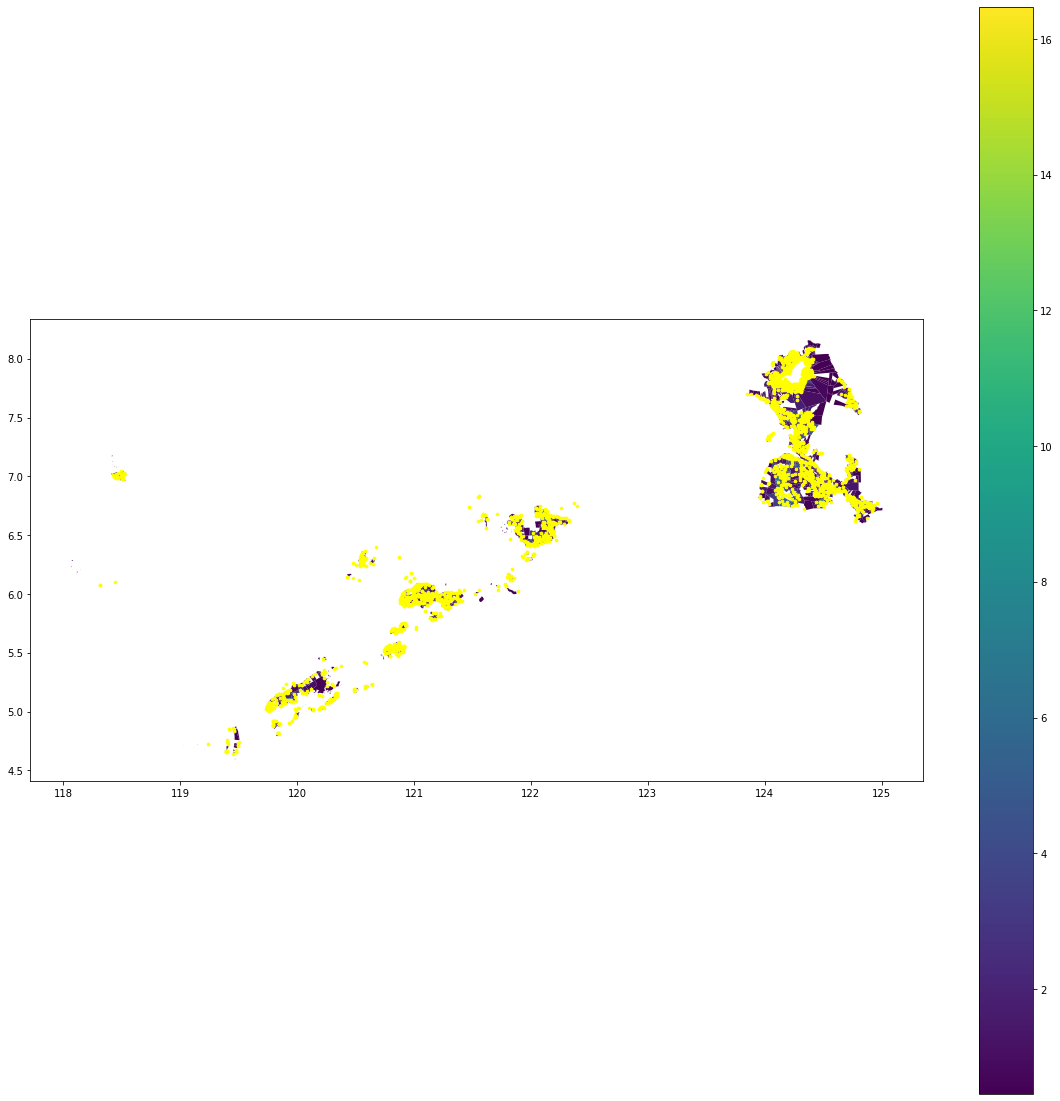

In [16]:
plot_access_measure('gravity_value')

In [17]:
school_access_df = school_access.access_df.dropna()
school_access_df.reset_index(inplace=True)
school_access_df.columns = ["PSGC_BRGY","Student_Popn_6_to_16","Access_Score"]
school_access_df.to_csv(OUTPUT_PATH+"Model_Access_Scores_General.csv",index=False)
school_access_df.head()

,PSGC_BRGY,Student_Popn_6_to_16,Access_Score
0,PH150702001,151.0,2.153343
1,PH150702002,318.0,2.545851
2,PH150702004,155.0,6.806820
3,PH150702005,612.0,2.890274
4,PH150702006,814.0,3.020273
